In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
# Step 1: Load the Stanford Dogs dataset from TensorFlow Datasets
(train_data, test_data), info = tfds.load('stanford_dogs', split=['train', 'test'], 
                                          with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /Users/kashishvarmaa/tensorflow_datasets/stanford_dogs/incomplete.PVTYMX_0.2.0/stanford_dogs-train.t…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /Users/kashishvarmaa/tensorflow_datasets/stanford_dogs/incomplete.PVTYMX_0.2.0/stanford_dogs-test.tf…

Dataset stanford_dogs downloaded and prepared to /Users/kashishvarmaa/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
# Step 2: Preprocess the data (Resize and Normalize)
IMG_SIZE = (224, 224)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

train_data = train_data.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Step 3: Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
# IMP !!!
''' Step 4 (Freezing Layers):
	•	You freeze the earlier layers of the pre-trained model and only fine-tune the last 10 layers by setting layer.trainable = False for the frozen layers.
	•	To adjust the number of layers for fine-tuning, modify the range in base_model.layers[:-10]. For example, if you want to fine-tune the last 20 layers, change it to base_model.layers[:-20].'''
# Step 4: Filter Fine-Tuning (Freeze and Unfreeze Layers)
# Freeze all layers except the last 10 (you can modify this number to adjust the filters)
for layer in base_model.layers[:-10]:  # Fine-tuning only the last 10 layers
    layer.trainable = False  # Freeze earlier layers to keep pre-trained filters

# Adding new layers for fine-tuning the model for the Stanford Dogs classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)

In [9]:
# Step 5: Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Step 6: Compile the model for fine-tuning with a small learning rate
optimizer = Adam(learning_rate=1e-4)  # Small learning rate for fine-tuning filters
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Step 7: Define Callbacks for Adaptive Learning Rate and Early Stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Step 8: Initial Training (fine-tuning the last few layers)
history = model.fit(train_data, validation_data=test_data, epochs=20, 
                    callbacks=[lr_reduction, early_stopping])

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1049s 3s/step - accuracy: 0.0655 - loss: 4.2770 - val_accuracy: 0.0442 - val_loss: 4.4488 - learning_rate: 5.0000e-05
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1267s 3s/step - accuracy: 0.0826 - loss: 4.1430 - val_accuracy: 0.0503 - val_loss: 4.4240 - learning_rate: 5.0000e-05
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2999s 8s/step - accuracy: 0.0980 - loss: 4.0273 - val_accuracy: 0.0502 - val_loss: 4.4464 - learning_rate: 5.0000e-05
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1527s 4s/step - accuracy: 0.1214 - loss: 3.9090 - val_accuracy: 0.0497 - val_loss: 4.4592 - learning_rate: 5.0000e-05
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1450 - loss: 3.7804
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
375/375 ━━━━━━━━━━━━━━━━━━━━ 1685s 4s/step - accuracy: 0.1450 - loss: 3.7804 - val_accuracy: 0.0458 - val_loss: 4.5185 - learning_rate: 5.0000e-05
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1632s 4s/step - accu

In [14]:
# IMPPP!!
'''Step 9 (Unfreezing More Layers):
	•	You can unfreeze more layers for further fine-tuning after initial training. Here, I’ve unfrozen the last 30 layers (base_model.layers[-30:]), but you can modify this value depending on how much of the model you want to fine-tune.
	•	To target specific filters or layers, adjust the number of layers you unfreeze. This gradual unfreezing helps in adaptive filter fine-tuning.
'''
# Step 9: Gradually Unfreeze More Layers for Further Filter Fine-Tuning
# Now we will unfreeze more layers for further fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze more layers as training progresses
    layer.trainable = True  # Fine-tuning filters in the last 30 layers

In [15]:
# Step 10: Re-compile the model with a lower learning rate
optimizer = Adam(learning_rate=1e-5)  # Lower learning rate for deeper fine-tuning
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Step 11: Continue training with fine-tuning on more layers
history_fine_tune = model.fit(train_data, validation_data=test_data, epochs=10, 
                              callbacks=[lr_reduction, early_stopping])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2130s 6s/step - accuracy: 0.0364 - loss: 4.5586 - val_accuracy: 0.0582 - val_loss: 4.3601 - learning_rate: 1.0000e-05
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1756s 5s/step - accuracy: 0.0833 - loss: 4.1382 - val_accuracy: 0.0684 - val_loss: 4.2699 - learning_rate: 1.0000e-05
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1202s 3s/step - accuracy: 0.1130 - loss: 3.9477 - val_accuracy: 0.0758 - val_loss: 4.2130 - learning_rate: 1.0000e-05
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1410s 4s/step - accuracy: 0.1454 - loss: 3.7813 - val_accuracy: 0.0754 - val_loss: 4.2106 - learning_rate: 1.0000e-05
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1743s 5s/step - accuracy: 0.1800 - loss: 3.6121 - val_accuracy: 0.0811 - val_loss: 4.2091 - learning_rate: 1.0000e-05
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2127s 6s/step - accuracy: 0.2183 - loss: 3.4394 - val_accuracy: 0.0834 - val_loss: 4.1928 - learning_rate: 1.0000e-05
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 978s 3s/step

In [17]:
# Step 12: Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

269/269 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.0832 - loss: 4.2046
Test Accuracy: 8.34%


In [18]:
# Step 14: Make predictions on new data
def predict_new_image(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize
    img = tf.expand_dims(img, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(img)
    predicted_class = tf.argmax(predictions[0])
    class_names = info.features['label'].int2str(predicted_class)
    print(f"Predicted Class: {class_names}")

# Example usage: predict_new_image("path_to_dog_image.jpg")

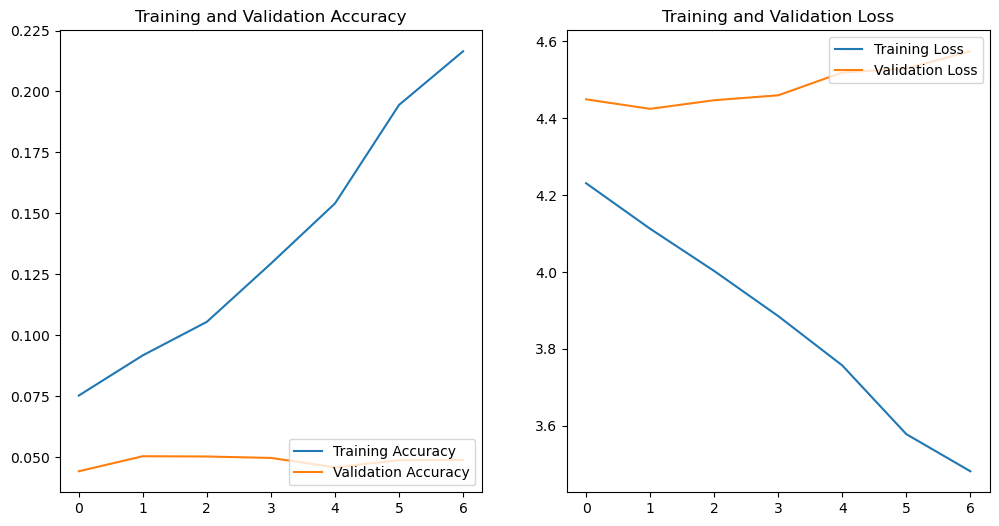

In [19]:
import matplotlib.pyplot as plt

# Step 15: Plot training & validation accuracy and loss values
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Call the function to plot the history of the fine-tuned model
plot_training_history(history)